In [62]:
from qiskit import *
from qiskit.circuit import Parameter, Gate
from qiskit.circuit.library import *
from qiskit.visualization import array_to_latex, plot_histogram
from qutip import hilbert_dist, Qobj, fock_dm

import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx

import numpy as np

First, lets take a look at the Toffoli gate

In [8]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
backend = BasicAer.get_backend('unitary_simulator')
job = backend.run(transpile(qc, backend))
ccx_gate = job.result().get_unitary(qc, decimals=2)
array_to_latex(ccx_gate)

<IPython.core.display.Latex object>

We can use the Hilbert Schmitt distance from the qutip library to get the hilbert distance between this and itself. Which of course will be 0

In [48]:
def get_hilber_shmidt_distance(gate1, gate2):
    return hilbert_dist(Qobj(gate1), Qobj(gate2))

def my_hilbert_schmidt_distance(gate1, gate2):
    return np.sqrt(1 - (np.abs(np.trace(np.conj(gate1).T @ gate2))**2) / (2**3)**2)

In [49]:
print("Hilbert Schmidt Distance of CCX with itself: ", get_hilber_shmidt_distance(ccx_gate, ccx_gate))
print("My Hilbert Schmidt Distance of CCX with itself: ", my_hilbert_schmidt_distance(ccx_gate, ccx_gate))

Hilbert Schmidt Distance of CCX with itself:  0.0
My Hilbert Schmidt Distance of CCX with itself:  0.0


In [130]:
# Simple method to apply a global phase to a quibit
def phase_shift(qc, theta, qubit):
    qc.p(theta, qubit)
    qc.x(qubit)
    qc.p(theta, qubit)
    qc.x(qubit)

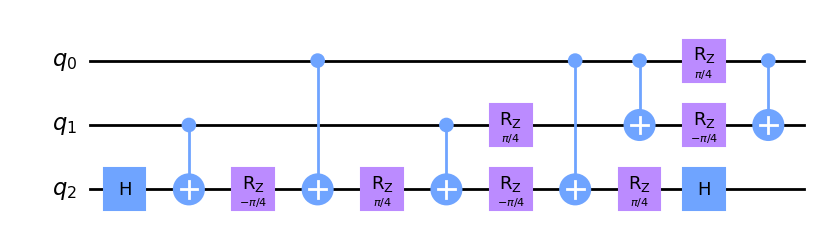

In [169]:
qc = QuantumCircuit(3)

qc.h(2)
qc.cnot(1, 2)
qc.rz(-np.pi/4, 2)
qc.cnot(0,2)
qc.rz(np.pi/4, 2)

qc.cnot(1,2)
qc.rz(-np.pi/4, 2)
qc.cnot(0, 2)
qc.rz(np.pi/4, 2)
qc.h(2)

qc.rz(np.pi/4, 1)
qc.cnot(0, 1)
qc.rz(-np.pi/4, 1)
qc.rz(np.pi/4, 0)
qc.cnot(0, 1)

qc.draw(output='mpl')

In [174]:
backend = BasicAer.get_backend('unitary_simulator')
job = backend.run(transpile(qc, backend))
global_phase = np.exp(1.j * np.pi/8)
approx_ccx = job.result().get_unitary(qc, decimals=2)
array_to_latex(approx_ccx)

<IPython.core.display.Latex object>

In [175]:
print("Hilbert Schmidt Distance of CCX with Approx CCX: ", np.abs(get_hilber_shmidt_distance(ccx_gate, approx_ccx)))
print("My Hilbert Schmidt Distance of CCX with Approx CCX: ", np.abs(my_hilbert_schmidt_distance(ccx_gate, approx_ccx)))

Hilbert Schmidt Distance of CCX with Approx CCX:  1.2064
My Hilbert Schmidt Distance of CCX with Approx CCX:  0.09591663046625432


Next, lets split up this circuit into two separate smaller circuits that have at most 4 CNOTs

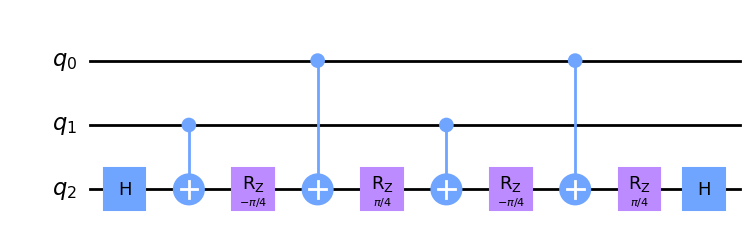

In [183]:
qc = QuantumCircuit(3)

qc.h(2)
qc.cnot(1, 2)
qc.rz(-np.pi/4, 2)
qc.cnot(0,2)
qc.rz(np.pi/4, 2)

qc.cnot(1,2)
qc.rz(-np.pi/4, 2)
qc.cnot(0, 2)
qc.rz(np.pi/4, 2)
qc.h(2)
CCNOT_U1 = qc.to_gate()

qc.draw(output='mpl')

In [182]:
backend = BasicAer.get_backend('unitary_simulator')
job = backend.run(transpile(qc, backend))
gate = job.result().get_unitary(qc, decimals=2)
array_to_latex(gate)

<IPython.core.display.Latex object>

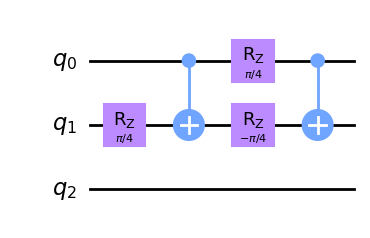

In [184]:
qc = QuantumCircuit(3)
qc.rz(np.pi/4, 1)
qc.cnot(0, 1)
qc.rz(-np.pi/4, 1)
qc.rz(np.pi/4, 0)
qc.cnot(0, 1)
CCNOT_U2 = qc.to_gate()
qc.draw(output="mpl")

In [185]:
backend = BasicAer.get_backend('unitary_simulator')
job = backend.run(transpile(qc, backend))
gate = job.result().get_unitary(qc, decimals=2)
array_to_latex(gate)

<IPython.core.display.Latex object>

In [ ]:
qc = QuantumCircuit(3)

qc.h(2)
qc.cnot(1, 2)
qc.rz(-np.pi/4, 2)
qc.cnot(0,2)
qc.rz(np.pi/4, 2)

qc.cnot(1,2)
qc.rz(-np.pi/4, 2)
qc.cnot(0, 2)
qc.rz(np.pi/4, 2)
qc.h(2)
CCNOT_U3 = qc.to_gate()

qc.draw(output='mpl')

In [216]:
def get_approx_CCNOT_unitary(gate_list):
    unitaries = []
    backend = BasicAer.get_backend('unitary_simulator')
    for gate in gate_list:
        qc = QuantumCircuit(3)
        qc.append(gate, [0, 1, 2])
        job = backend.run(transpile(qc, backend))
        res_unitary = job.result().get_unitary(qc, decimals=2)
        unitaries.append(res_unitary)

    return sum(unitaries) / len(unitaries)


approx_CCNOT_U = get_approx_CCNOT_unitary([CCNOT_U1])
array_to_latex(approx_CCNOT_U)

<IPython.core.display.Latex object>

In [217]:
print("My Hilbert Schmidt Distance of CCX with Approx CCX: ", np.abs(my_hilbert_schmidt_distance(ccx_gate, approx_CCNOT_U)))

My Hilbert Schmidt Distance of CCX with Approx CCX:  0.6123724356957945


Here is the generic single qubit unitary

In [47]:
class SingleQubitU(Gate):
    def __init__(self, theta, phi, lam):
        super().__init__('U1', 1, [theta, phi, lam])
    
    def _define(self):
        qc = QuantumCircuit(1)
        qc.unitary(self.to_matrix(), [0])
        self.definition = qc
    
    def to_matrix(self):
        theta = float(self.params[0])
        phi = float(self.params[1])
        lam = float(self.params[2])
        return UGate(theta, phi, lam).to_matrix()
        # return np.array([[np.cos(theta/2), -np.exp(1.j * lam) * np.sin(theta/2)],
        #                  [np.exp(1.j * phi) * np.sin(theta/2), np.exp(1.j * (phi + lam)) * np.cos(theta/2)]])

In [56]:
class TwoQubitU(Gate):
    def __init__(self, alpha1, alpha2, alpha3):
        super().__init__('U2', 2, [alpha1, alpha2, alpha3])
    def _define(self):
        qc = QuantumCircuit(2)
        qc.unitary(self.to_matrix(), [0, 1])
        self.definition = qc
    def to_matrix(self):
        alpha1 = float(self.params[0])
        alpha2 = float(self.params[1])
        alpha3 = float(self.params[2])

        rxx_gate = RXXGate(alpha1).to_matrix()
        ryy_gate = RYYGate(alpha2).to_matrix()
        rzz_gate = RZZGate(alpha3).to_matrix()
        return rxx_gate @ ryy_gate @ rzz_gate 

        # return CU3Gate(alpha1, alpha2, alpha3).to_matrix()

        # return np.array([[np.cos(alpha1/2), 0, 0, -np.exp(1.j * alpha3) * np.sin(alpha1/2)],
        #                  [0, np.cos(alpha2/2), -np.exp(1.j * alpha3) * np.sin(alpha2/2), 0],
        #                  [0, -np.exp(1.j * alpha3) * np.sin(alpha2/2), np.cos(alpha2/2), 0],
        #                  [-np.exp(1.j * alpha3) * np.sin(alpha1/2), 0, 0, np.cos(alpha1/2)]])
    

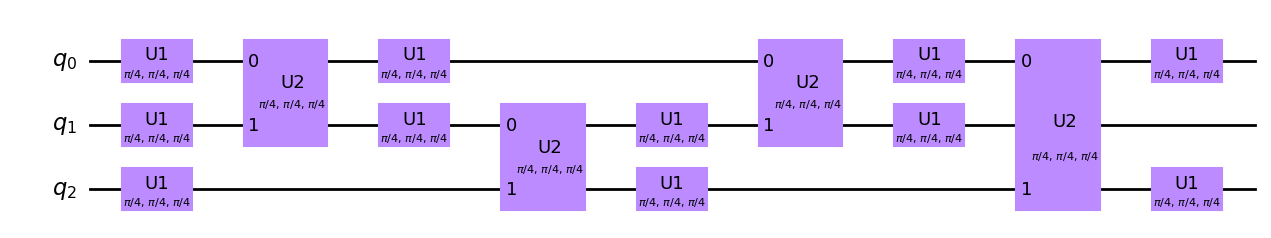

In [57]:
qc = QuantumCircuit(3, name="Approx CCNOT")

# Define parameters
theta = Parameter('theta')
phi = Parameter('phi')
lam = Parameter('lam')

# Create the circuit
qc.append(SingleQubitU(theta, phi, lam), [0])
qc.append(SingleQubitU(theta, phi, lam), [1])
qc.append(SingleQubitU(theta, phi, lam), [2])

qc.append(TwoQubitU(theta, phi, lam), [0, 1])

qc.append(SingleQubitU(theta, phi, lam), [1])

qc.append(SingleQubitU(theta, phi, lam), [0])
qc.append(TwoQubitU(theta, phi, lam), [1, 2])

qc.append(SingleQubitU(theta, phi, lam), [1])

qc.append(TwoQubitU(theta, phi, lam), [0, 1])

qc.append(SingleQubitU(theta, phi, lam), [0])
qc.append(SingleQubitU(theta, phi, lam), [1])
qc.append(SingleQubitU(theta, phi, lam), [2])

qc.append(TwoQubitU(theta, phi, lam), [0, 2])

qc.append(SingleQubitU(theta, phi, lam), [0])
qc.append(SingleQubitU(theta, phi, lam), [2])

bound_qc = qc.bind_parameters({theta: np.pi/4, phi: np.pi/4, lam: np.pi/4})
bound_qc.draw(output='mpl')

In [58]:
backend = BasicAer.get_backend('unitary_simulator')
job = backend.run(transpile(bound_qc, backend))
gate = job.result().get_unitary(bound_qc, decimals=2)
array_to_latex(gate)

<IPython.core.display.Latex object>

In [64]:
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

def f(x):
    return x[0]**2 + x[1]**2

# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=2, options=options)

# Perform optimization
cost, pos = optimizer.optimize(f, iters=1000)

2023-02-21 20:36:49,658 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1000


TypeError: f() missing 1 required positional argument: 'y'

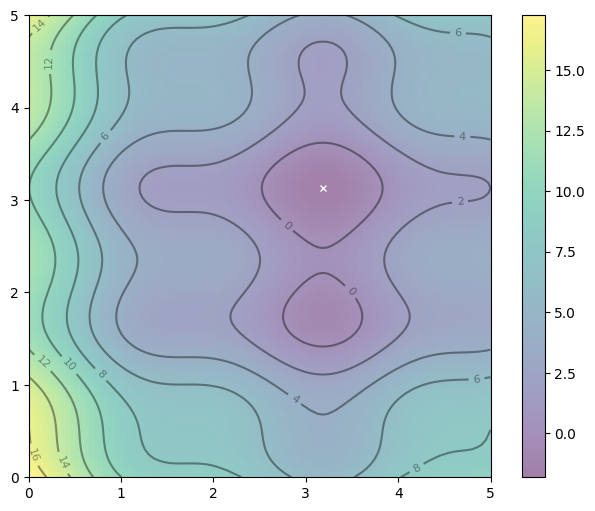

In [59]:
import matplotlib.pyplot as plt
 
def f(x,y):
    "Objective function"
    return (x-3.14)**2 + (y-2.72)**2 + np.sin(3*x+1.41) + np.sin(4*y-1.73)
 
# Contour plot: With the global minimum showed as "X" on the plot
x, y = np.array(np.meshgrid(np.linspace(0,5,100), np.linspace(0,5,100)))
z = f(x, y)
x_min = x.ravel()[z.argmin()]
y_min = y.ravel()[z.argmin()]
plt.figure(figsize=(8,6))
plt.imshow(z, extent=[0, 5, 0, 5], origin='lower', cmap='viridis', alpha=0.5)
plt.colorbar()
plt.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = plt.contour(x, y, z, 10, colors='black', alpha=0.4)
plt.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
plt.show()